# Detecting P300 
In this notebook we will develop a script for processing and identifying P300 responses. We are going to start by visualizing the responses and then perform machine learning on them. We will walk through the steps you need to take to do this. Note: this notebook uses the Python 2.7 kernel. You may need to change the script for it to work with Python 3.

This notebook and related process is based on the work of Aaron Newman and Colin Conrad. It follows the MIT lisence though, so feel free to use it and change it however you would like -- just make sure you credit this work! 

## Import the necessary libraries
We will need to import a large number of libraries (such as MNE and scikit-learn) as well as datasets. If you are not familiar with Python, don't worry, we will work through these together soon.

In [1]:
#note: using the Python 2.7 kernel
import numpy as np
import matplotlib, mne
from mne.io.reference import set_eeg_reference

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from mne import io, pick_types, read_events, Epochs
from mne.decoding import Vectorizer
from mne.viz import tight_layout
from mne.preprocessing import Xdawn

mne.set_log_level('error')

subject = 'p300-speller-new-02' #this is the name of the subject

event_id = {'Nontarget':1, 'Target':2}

cond_of_interest = sorted(event_id.keys())

# specify the time window for epoching
tmin = -0.1  # start of each epoch (in sec)
tmax =  0.5  # end of each epoch (in sec); 300 ms in this case

# './' specifies that data are in the same directory as this notebook
data_path = './eeg_recordings/' 

# Input should be continuous EEG data in EEGLAB format, named as [subject].set
raw_fname = data_path + subject + '.set' #raw_fname = data_path + subject + '.vhdr'

# We have EOG but we didn't use them.
eog_inds = ['VEOG', 'HEOG']

# Filter cutoffs and other parameters
l_freq = 0.1
h_freq = 40.0
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run
n_max_ecg = 3
n_max_eog = 3
# Specify n_components as a decimal to set % explained variance
n_components = .99

#################################################################
# It's unlikely you will want to change any settings below here

baseline = None  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1020' #1005

# output file names - set to follow MNE conventions
events_fname = data_path + subject + '-eve.fif'
epochs_fname  = data_path + subject + '-epo.fif'
evoked_fname = data_path + subject + '--ave.fif'
covariance_fname = data_path + subject + '-cov.fif'
trans_name = data_path + subject + '-trans.fif'
forward_fname = data_path + subject + '-fwd.fif'
inverse_fname = data_path + subject + '-inv.fif'

## Import data

In [2]:
raw = mne.io.read_raw_eeglab(raw_fname, 
                          eog=eog_inds, 
                          event_id=event_id, 
                          montage=montage_fname,
                          preload=True) 

## Filtering

### First plot frequency spectrum prior to filtering, for later comparison

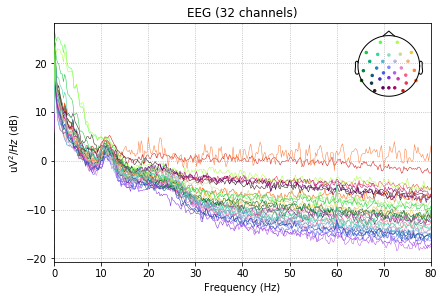

In [3]:
raw.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=8);

### Now bandpass filter, then plot filtered data

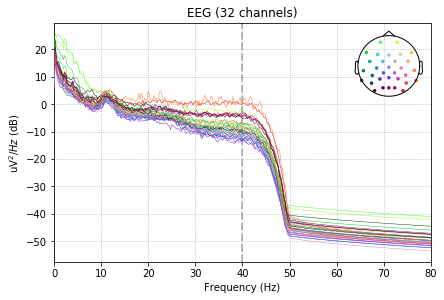

In [4]:
raw.filter(l_freq, h_freq, 
           l_trans_bandwidth = l_trans_bandwidth, 
           h_trans_bandwidth = h_trans_bandwidth, 
           filter_length=filter_length, 
           method='fft', 
           n_jobs = 4)  

raw.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=8);

## Interactive plot of continuous data - identify and mark bad channels
Scroll through the plot to identify channels for exclusion from analysis. In this case the channels more-or-less look good, but with lots of blinks. Note, this tool is usually quite unstable. You might have to run the command multiple times before you can interact with the tool.

<IPython.core.display.Javascript object>


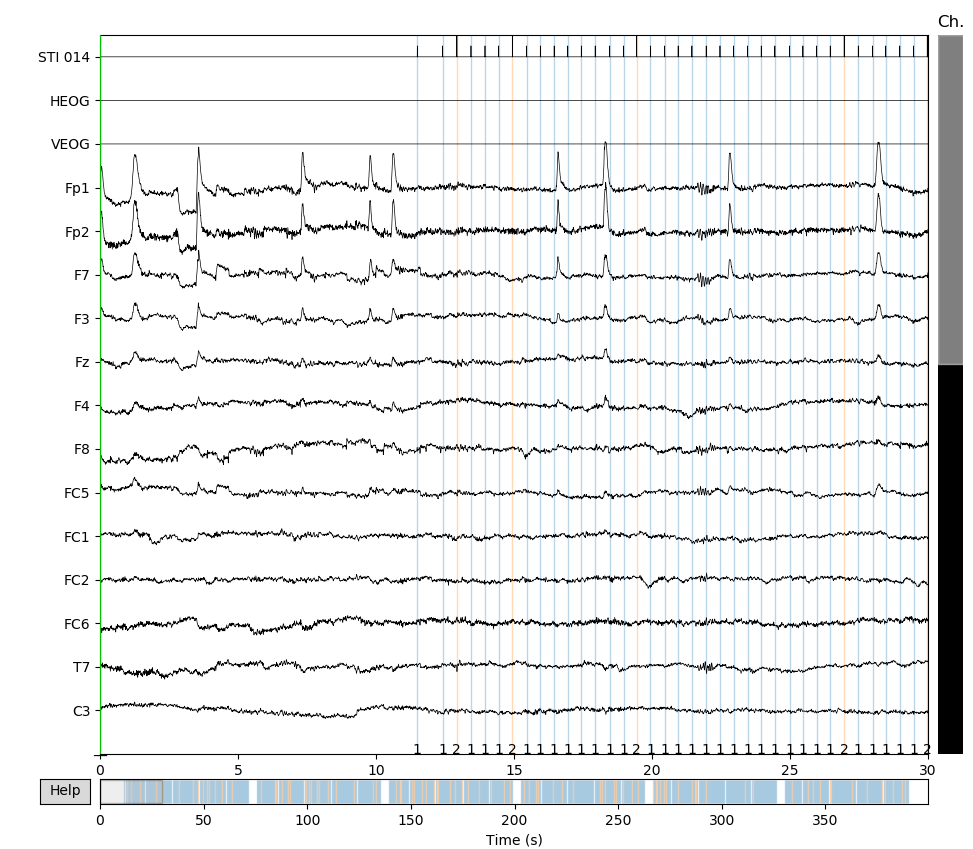

In [5]:
%matplotlib notebook
raw.plot(n_channels=16, scalings=dict(eeg=.0001), duration=30, title='Raw EEG');

We ill remove the EOGs because they were not used, even though the EEG system was set up to use them.

In [6]:
raw.info['bads'] = ['HEOG', 'VEOG'] 

# Event Processing
Event codes are stored in a 'channel' called STI 014; we recoreded the target and nontarget stimuli using this. We will retrieve these codes at this step and save them for later analysis.

### A plot to visualize the new event times

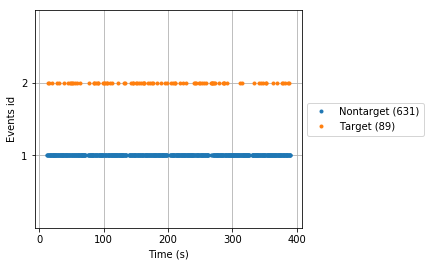

In [7]:
%matplotlib inline
events = mne.find_events(raw) 
fig = mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id);

## Epoching
This is the step of turning data into time-locked events called epochs. We will actually analyze epochs in this exercise, not the raw EEG data. In regular EEG analysis, we manually inspect epochs to ensure data quality. We will skip this process, but I will leave the code and visualizations for your reference, in case you want to do that.

In [8]:
picks_eeg = mne.pick_types(raw.info, eeg=True, eog=True,
                           stim=False, exclude=[]) 

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks_eeg, baseline=baseline, preload=True)

print(epochs) # gives us number of trials per condition prior to artrej

<Epochs  |   720 events (all good), -0.0996094 - 0.5 sec, baseline off, ~57.6 MB, data loaded,
 'Nontarget': 631
 'Target': 89>


## Plot epochs and go through, manually marking bad trials
Click on a trial to mark it bad. When you close the window, the marked trials will be saved to the "drops" in the epochs data structure.

<IPython.core.display.Javascript object>


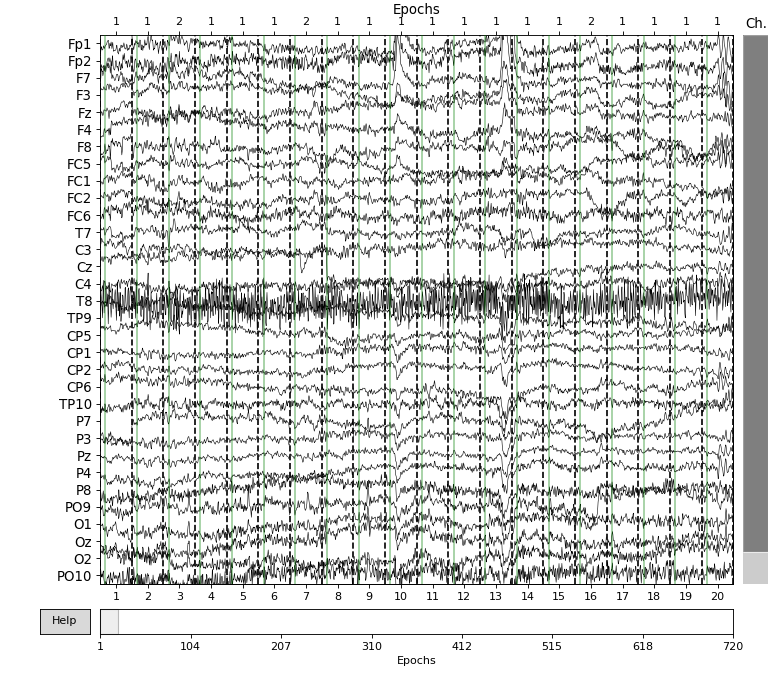

In [9]:
%matplotlib notebook
epochs.plot(scalings=dict(eeg='auto'), n_channels=32, title='Epochs', picks=picks_eeg);

#### Epochs to be rejected
We will not reject any epochs this time around.

In [10]:
rej_trials = [] 
for k in range(len(rej_trials)):
    rej_trials[k] = rej_trials[k]-1
    
epochs.drop(rej_trials)

<Epochs  |   720 events (all good), -0.0996094 - 0.5 sec, baseline off, ~57.6 MB, data loaded,
 'Nontarget': 631
 'Target': 89>

### Plot average of all epochs
You should see big artifacts in the data, since we haven't done artifact correction yet. For the record, this is very messy.

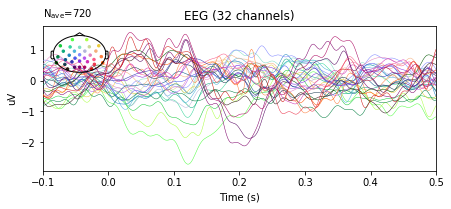

In [11]:
%matplotlib inline
epochs.average().plot(spatial_colors=True);

# Run ICA to identify and correct ocular artifacts
In regular EEG analysis, we run ICA to get rid of artifacts. We will still use this process, but there are many problems with the way we will apply it here.

In [12]:
n_components = .99

ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(epochs.info, meg=False, 
                       eeg=True, eog=False, stim=False, exclude='bads')

ica.fit(epochs, picks=picks, decim=3, reject=None)

<ICA  |  epochs decomposition, fit (fastica): 74160 samples, 28 components, channels used: "eeg">

### Plot scalp maps of each Independent Component
Ocular artifact components should load heavily over the front of the head and little/not at all elsewhere.

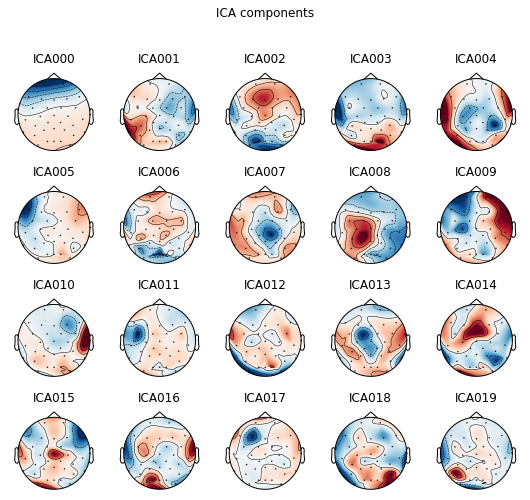

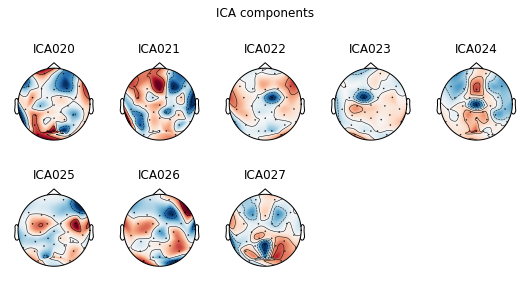

In [13]:
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection

My criteria for rejection are:
1. Obvious ocular artifact (blinks weigh heavily on anterior channels, all same polarity; horizontal movements weight heavily on either side of the eyes, with opposite polarity on each side)
- Raster plots show that component weights heavily on a very low number of trials, and little/not at all on most trials
- "Epochs variance" is high on a low number of trials, and generally low on most trials
- Topo plot shows a very focal effect around a single electrode, with very little/no weighting at most other electrodes (keeping in mind that the topo plots are interpolated so there will be some "smearing" of an effect even at a single electrode) 
- No apparent correlation between average waveform (shown in bottom of raster plot) and an IC with a clear, strong, sensory ERP (i.e., no suggestion of part or all of a P1-N-P2 complex)

Need to manually change the "picks" number for each plot based on visual inspection of the topo plots of the components, above.

C:\Users\cconrad\Miniconda2\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


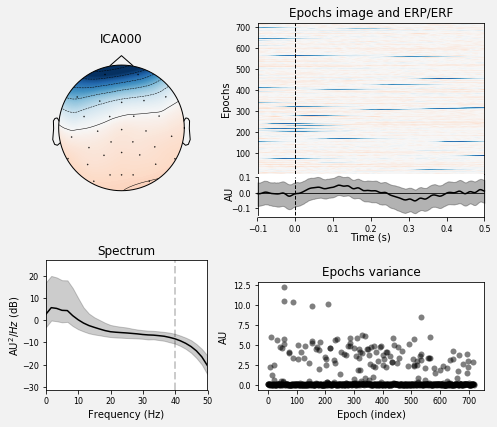

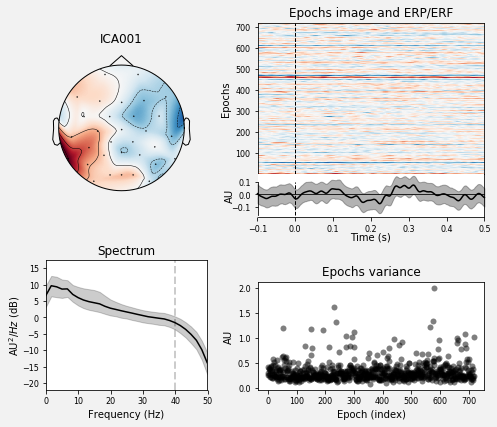

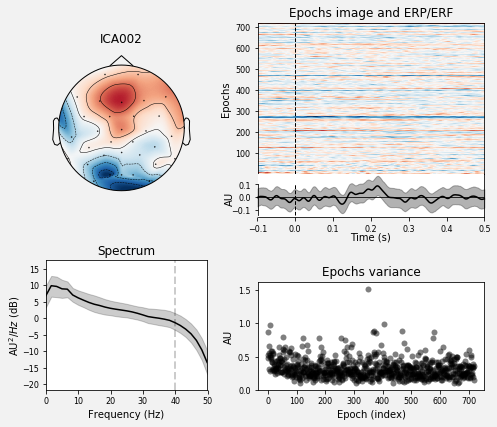

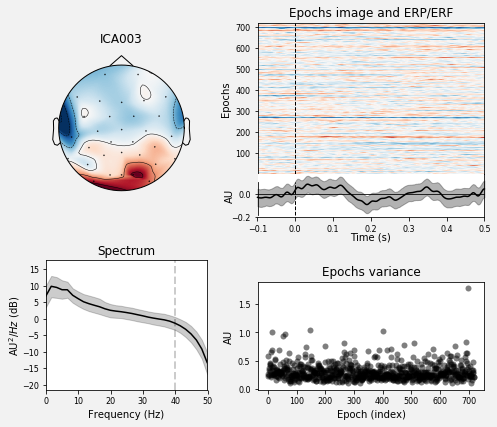

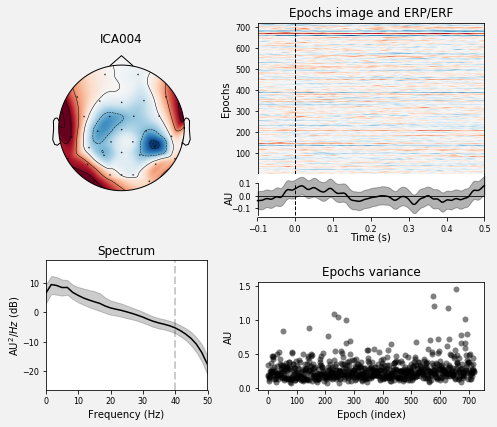

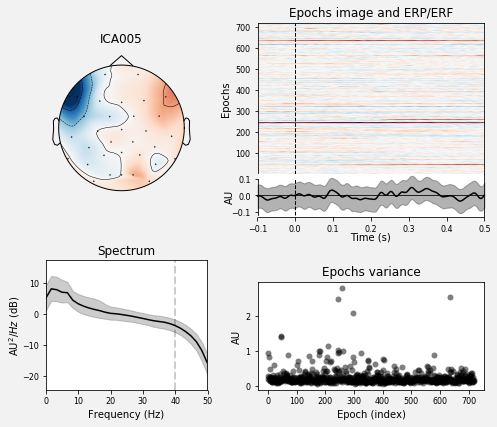

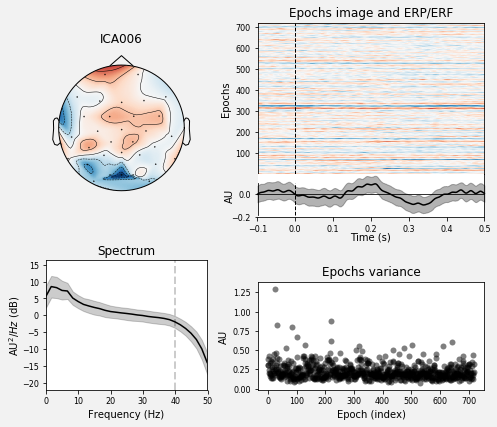

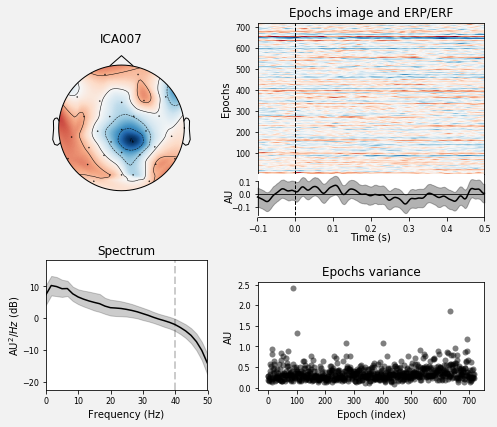

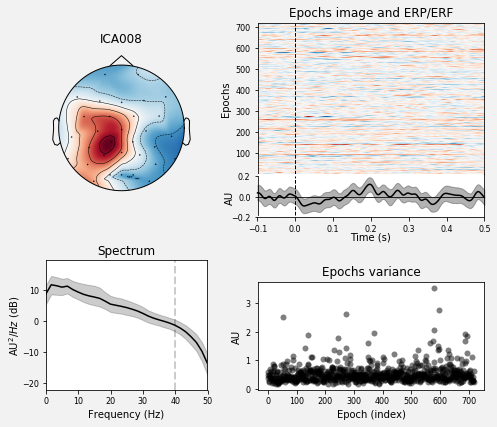

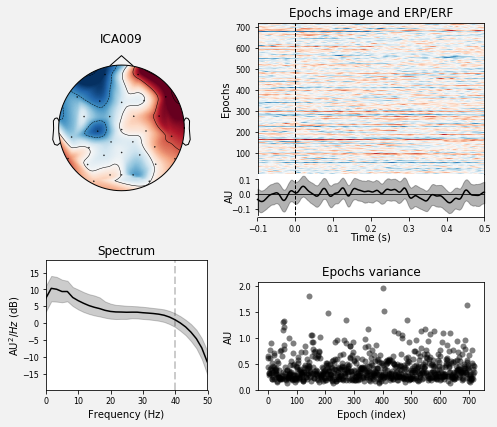

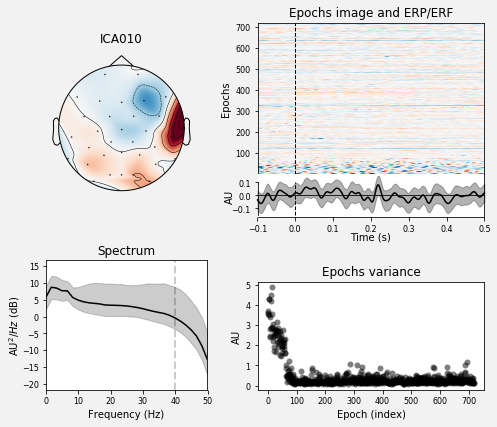

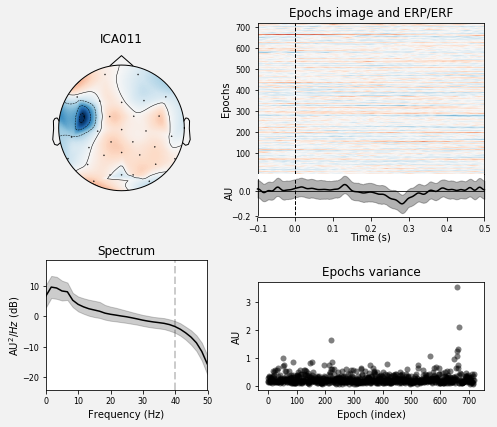

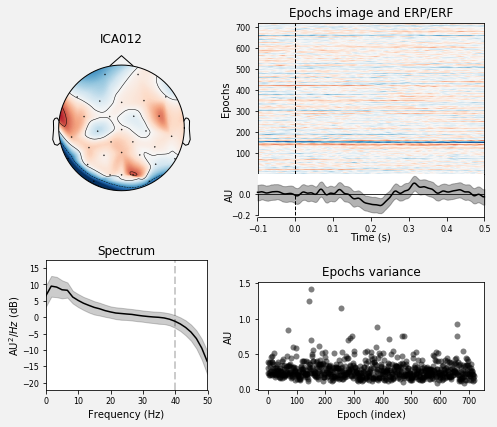

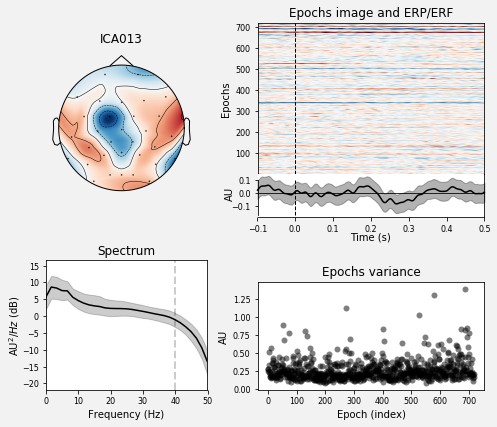

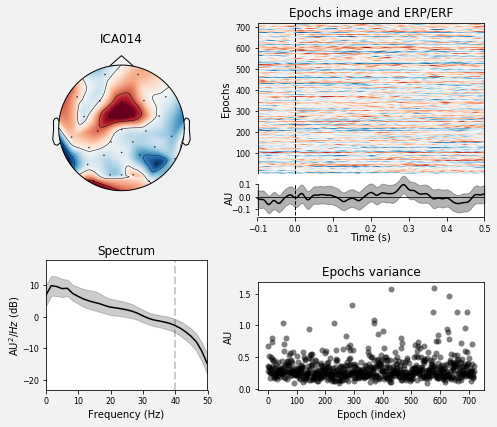

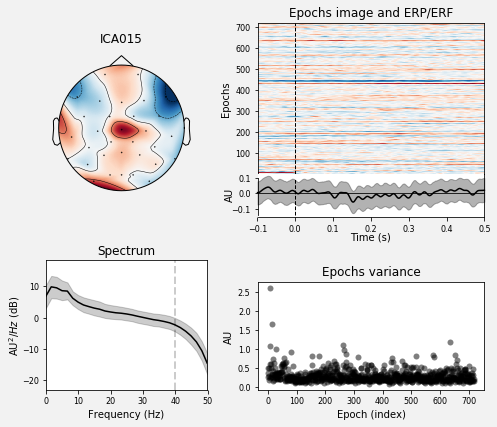

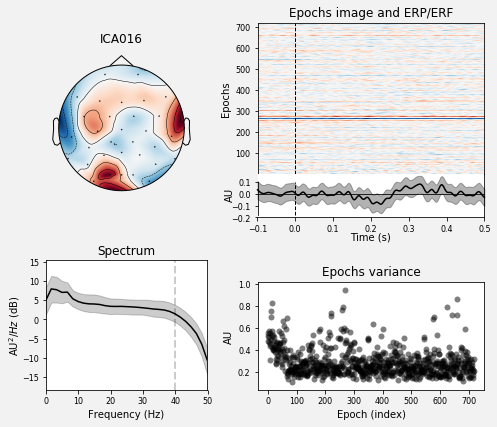

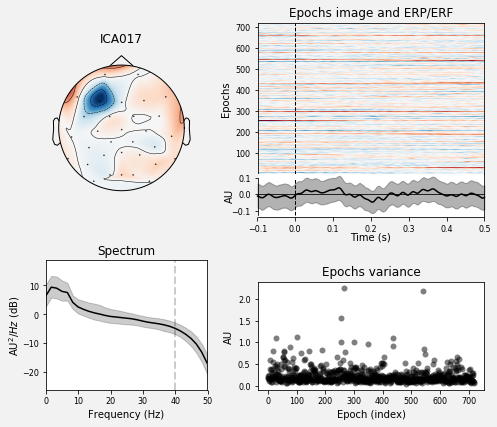

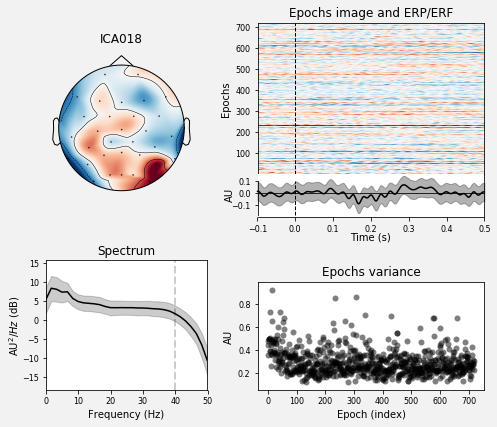

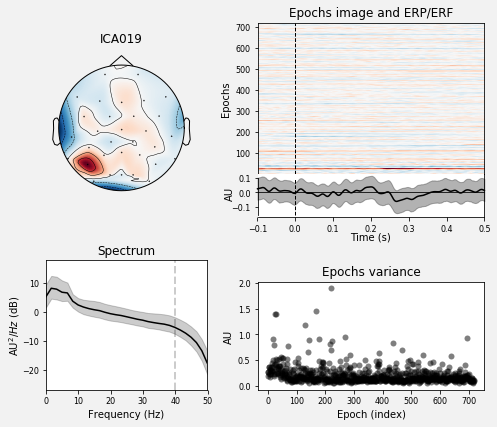

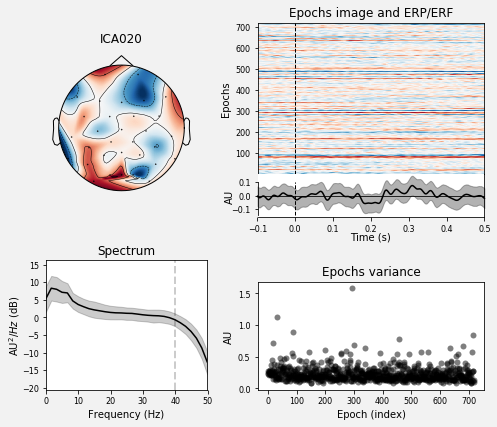

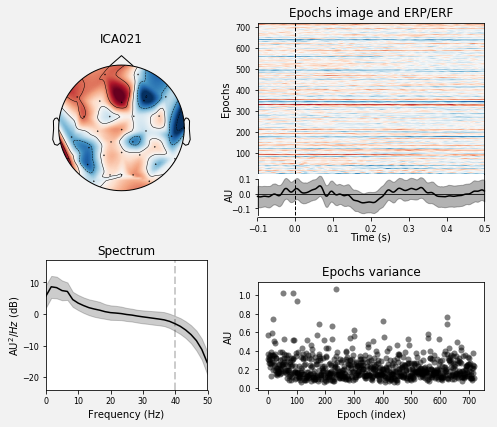

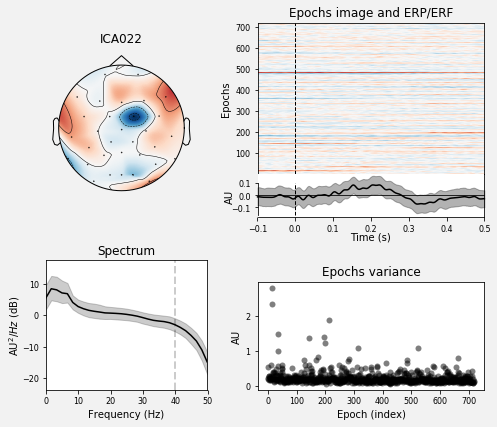

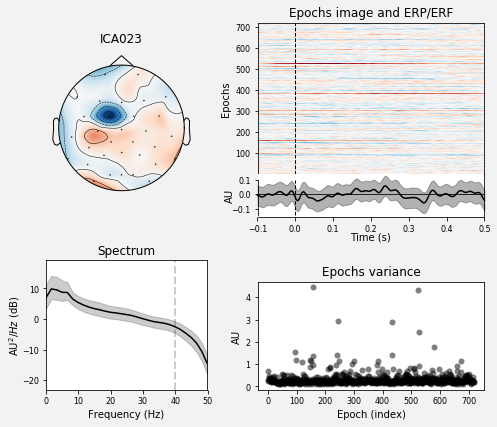

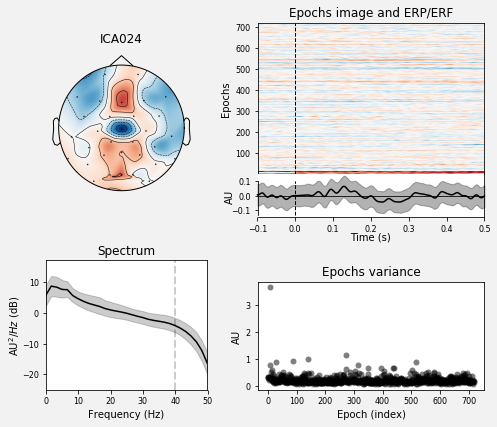

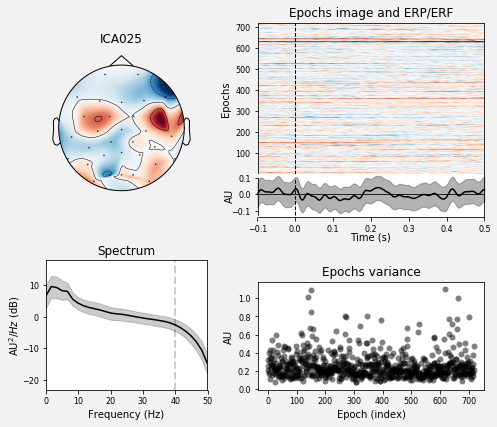

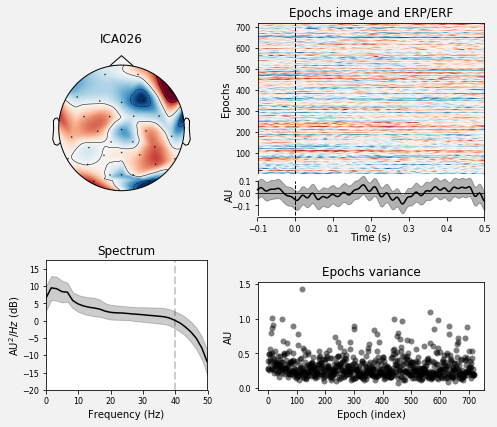

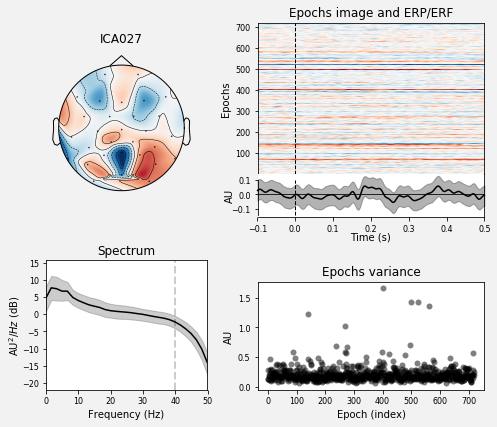

In [14]:
ica.plot_properties(epochs, picks=range(0,ica.n_components_));

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [24]:
ica.exclude = [0,10,11,23,24] #fiarly clean data

# Apply ICA corrections to data, and re-reference to average mastoids

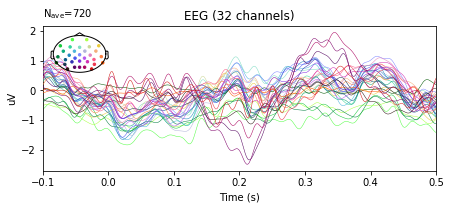

In [25]:
epochs_postica = ica.apply(epochs.copy()).apply_baseline(baseline)
epochs_postica_mstd = set_eeg_reference(epochs_postica, ref_channels=['TP9','TP10'])[0]
epochs_postica_mstd.interpolate_bads()
epochs_postica_mstd.average().plot(spatial_colors=True);
epochs_postica_mstd.save(epochs_fname)

# Create Evoked Responses (averaged epochs for each condition)
This will save a file of the evoked data as well, which you will load in later, in a different script, for group data analysis).

In [26]:
evokeds = {cond:epochs_postica_mstd[cond].average() for cond in event_id.keys()}
mne.write_evokeds(evoked_fname, list(evokeds.values()))

In [27]:
evokeds

{'Nontarget': <Evoked  |  'Nontarget' (mean, N=631), [-0.099609, 0.5] sec, 32 ch, ~167 kB>,
 'Target': <Evoked  |  'Target' (mean, N=89), [-0.099609, 0.5] sec, 32 ch, ~167 kB>}

### Plot averaged ERP for each condition
Note that for any image in a jupyter notebook (such as these plots), you can right-click and "save as" to save it as an image file (e.g., for inclusion in your lab report).

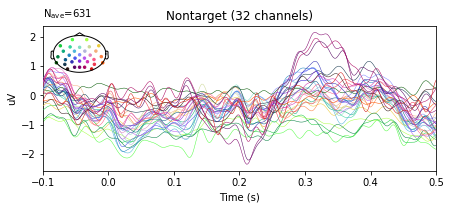

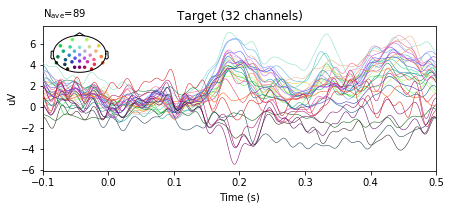

In [28]:
for cond in evokeds:
    evokeds[cond].plot(spatial_colors=True, titles=cond);

### Topoplots for each condition

There seem to be some differences in the timing of the evoked potential in the MW condition and regular conditions. This is strong evidence _against_ the significance of the oddball.

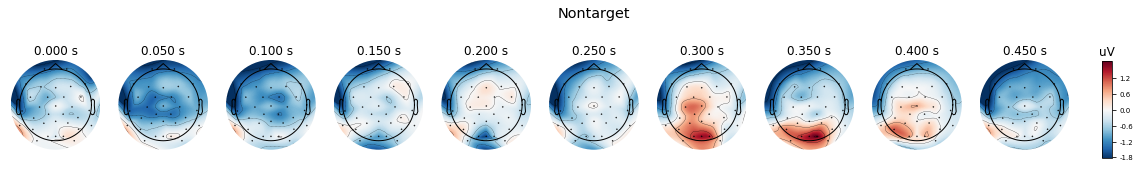

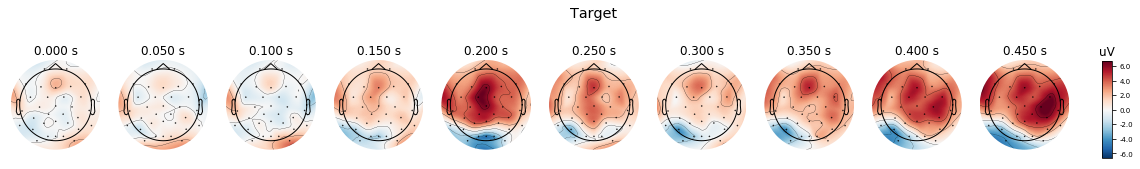

In [29]:
%matplotlib inline
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, 0.5, 0.05) #changed to visualize the 500 ms timespan

for cond in evokeds:
    [evokeds[cond].plot_topomap(outlines='skirt', times=times, title=cond)];

## Plot each condition, overlaid, at one electrode

You can replace 'P4' with desired channel name.

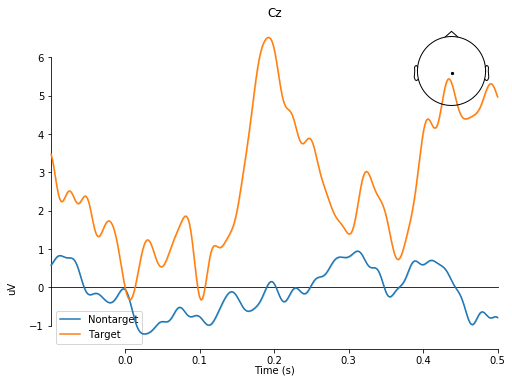

In [30]:
picks = evokeds[list(evokeds.keys())[0]].ch_names.index('Cz')

mne.viz.plot_compare_evokeds(evokeds, picks=picks, vlines=[]);

In [31]:
picks = [evokeds[list(evokeds.keys())[0]].ch_names.index('Fz'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('F3'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('F4'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('Cz'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('C3'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('C4'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('Pz'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('P3'), 
         evokeds[list(evokeds.keys())[0]].ch_names.index('P4'),
        ]

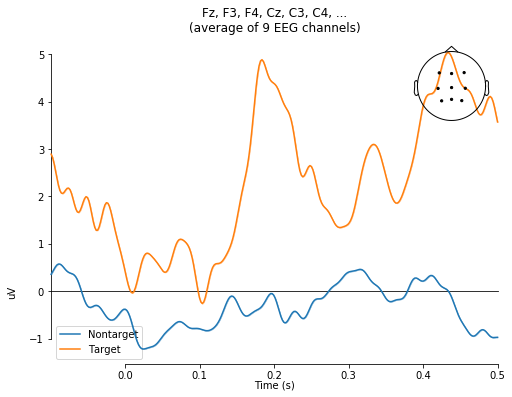

In [32]:
mne.viz.plot_compare_evokeds(evokeds, picks=picks, vlines=[]);

# Perform Machine Learning
We will also perform simple classification. We will not get good results following these steps, but it's a starting point in cas you want to continue. The data was problematic this time around, so I would be skeptical of the results produced.

In [33]:
# start by specifying labels and by creating a new copy of the original, unfiltered epochs
labels = epochs.events[:, -1]
new_epochs = epochs

In [34]:
len(new_epochs)

720

## Machine Learning Classification

Based on https://www.martinos.org/mne/stable/auto_examples/decoding/plot_decoding_xdawn_eeg.html#sphx-glr-auto-examples-decoding-plot-decoding-xdawn-eeg-py

This classifier will just go to majority class. We need to implement a downsampler first.

In [36]:
from sklearn.utils import resample

#produces a list of individual epochs
nontarget_downsampled = resample(new_epochs['Nontarget'], 
                                 replace=False,    # sample without replacement
                                 n_samples=89,     # to match minority class
                                 random_state=123) # reproducible results

#concatenate them into nontargets
nontarget_downsampled = mne.concatenate_epochs(nontarget_downsampled)

targets = new_epochs['Target']

#concatenate to downsized sample
epochs_downsampled = mne.concatenate_epochs([targets, nontarget_downsampled])

downsized_labels = epochs_downsampled.events[:, -1]

In [37]:
epochs_downsampled

<Epochs  |   178 events (all good), -0.0996094 - 0.5 sec, baseline off, ~14.3 MB, data loaded,
 'Nontarget': 89
 'Target': 89>

### Now classify using LogisticRegression

In [42]:
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1', solver='liblinear',
                                       multi_class='auto'))

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #split into the n-folds for n-fold cross validation

preds = np.empty(len(downsized_labels))

for train, test in cv.split(epochs_downsampled, downsized_labels):
    clf.fit(epochs_downsampled[train], downsized_labels[train])
    preds[test] = clf.predict(epochs_downsampled[test])
    
report = classification_report(downsized_labels, preds)
acc = accuracy_score(downsized_labels, preds)
    
print"Logistic Regression Classification for EEG Set 1: " + str(acc)
print report #use this for a detailed report including precision, recall and f-measure

Logistic Regression Classification for EEG Set 1: 0.5955056179775281
              precision    recall  f1-score   support

           1       0.60      0.60      0.60        89
           2       0.60      0.60      0.60        89

   micro avg       0.60      0.60      0.60       178
   macro avg       0.60      0.60      0.60       178
weighted avg       0.60      0.60      0.60       178



### Now classify using Support Vector Machines

In [43]:
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    svm.SVC(gamma='scale'))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #split into the n-folds for n-fold cross validation

preds = np.empty(len(downsized_labels))

for train, test in cv.split(epochs_downsampled, downsized_labels):
    clf.fit(epochs_downsampled[train], downsized_labels[train])
    preds[test] = clf.predict(epochs_downsampled[test])
    
report = classification_report(downsized_labels, preds)
acc = accuracy_score(downsized_labels, preds)
    
print"SVM Classification for EEG Set 1: " + str(acc)
print report #use this for a detailed report including precision, recall and f-measure

SVM Classification for EEG Set 1: 0.5955056179775281
              precision    recall  f1-score   support

           1       0.58      0.66      0.62        89
           2       0.61      0.53      0.57        89

   micro avg       0.60      0.60      0.60       178
   macro avg       0.60      0.60      0.59       178
weighted avg       0.60      0.60      0.59       178



### Now classify using Linear Discriminant Analysis

In [ ]:
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LinearDiscriminantAnalysis(priors=None, shrinkage='auto', solver='lsqr'))

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #split into the n-folds for n-fold cross validation

preds = np.empty(len(downsized_labels))

for train, test in cv.split(epochs_downsampled, downsized_labels):
    clf.fit(epochs_downsampled[train], downsized_labels[train])
    preds[test] = clf.predict(epochs_downsampled[test])
    
report = classification_report(downsized_labels, preds)
acc = accuracy_score(downsized_labels, preds)
    
print"LDA Classification for EEG Set 1: " + str(acc)
print report #use this for a detailed report including precision, recall and f-measure